In [1]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='make_profiles',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 
cluster.scale(168)
cluster

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


In [2]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://172.30.100.4:41401 Dashboard: http://172.30.100.4:34397/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           8210859     hsw24 make_pro albert7a PD       0:00      1 (None)
           8210860     hsw24 make_pro albert7a PD       0:00      1 (None)
           8210861     hsw24 make_pro albert7a PD       0:00      1 (None)
           8210862     hsw24 make_pro albert7a PD       0:00      1 (None)
           8210863     hsw24 make_pro albert7a PD       0:00      1 (None)
           8210864     hsw24 make_pro albert7a PD       0:00      1 (None)
           8207416     hsw24 make_pro albert7a  R      21:41      1 n3097
           8207417     hsw24 make_pro albert7a  R      21:41      1 n2225
           8207418     hsw24 make_pro albert7a  R      21:41      1 n2226
           8207419     hsw24 make_pro albert7a  R      21:41      1 n2227
           8207420     hsw24 make_pro albert7a  R      21:41      1 n2228
           8207421     hsw24 make_pro albert7a  R      21:41      1 n2229
           8209644   

In [4]:
import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

2


In [5]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           8209743     hsw24 make_pro albert7a  R       6:46      1 n2532
           8209744     hsw24 make_pro albert7a  R       6:46      1 n2533
           8209745     hsw24 make_pro albert7a  R       6:46      1 n2534
           8209746     hsw24 make_pro albert7a  R       6:46      1 n2535
           8209747     hsw24 make_pro albert7a  R       6:46      1 n2537
           8209748     hsw24 make_pro albert7a  R       6:46      1 n2538
           8210859     hsw24 make_pro albert7a  R       0:39      1 n2240
           8210860     hsw24 make_pro albert7a  R       0:39      1 n2404
           8210861     hsw24 make_pro albert7a  R       0:39      1 n2405
           8210862     hsw24 make_pro albert7a  R       0:39      1 n2406
           8210863     hsw24 make_pro albert7a  R       0:39      1 n2407
           8210864     hsw24 make_pro albert7a  R       0:39      1 n2408


In [6]:
import os
import sys
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean
import glob

%matplotlib inline


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [7]:
#params

plot_eke_monthly=False
plot_eke_12_month=True
plot_eke_annual=False


In [8]:
config='NATL60'
case='CJM165'
freq='1d'
#year='2010' #depends on the month

datadir='/store/molines/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'
#!ls $datadir
gridfile='/store/molines/NATL60/NATL60-I/NATL60_coordinates_v4.nc'
maskfile='/store/molines/NATL60/NATL60-I/NATL60_v4.1_cdf_byte_mask.nc'

In [9]:
dsgrid=xr.open_dataset(gridfile)
dsmask=xr.open_dataset(maskfile)

In [10]:
def compute_TKE(u2mean,v2mean):
    ua=0.5*(u2mean+u2mean.shift(x=1))
    va=0.5*(v2mean+v2mean.shift(y=1))
    uat=ua.rename({'depthu':'deptht'})
    vat=va.rename({'depthv':'deptht'})
    tke=0.5*(uat+vat)
    return tke


In [11]:
month_name={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
def plot_one_month(var,mask,vmin,vmax,cmap,title,figfile,month,year):
    fig, ax = plt.subplots(1,1,figsize=(10,15))
    var.where(mask==1).plot(cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,add_labels=True)
    ax.set_title(month_name[month])
    fig.suptitle('Monthly mean of '+str(title))
    plt.savefig('Plots/'+config+'/Maps/EU/'+config+'-'+case+'y'+str(year)+'m'+str(month)+'_'+figfile+'.png')

Plotting for month 7
Plotting for month 8


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Plotting for month 9


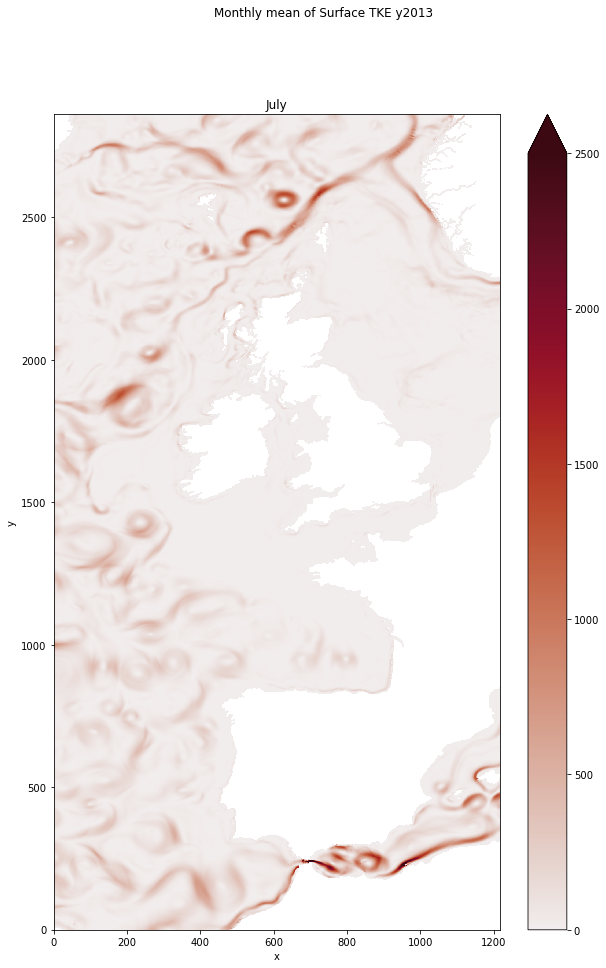

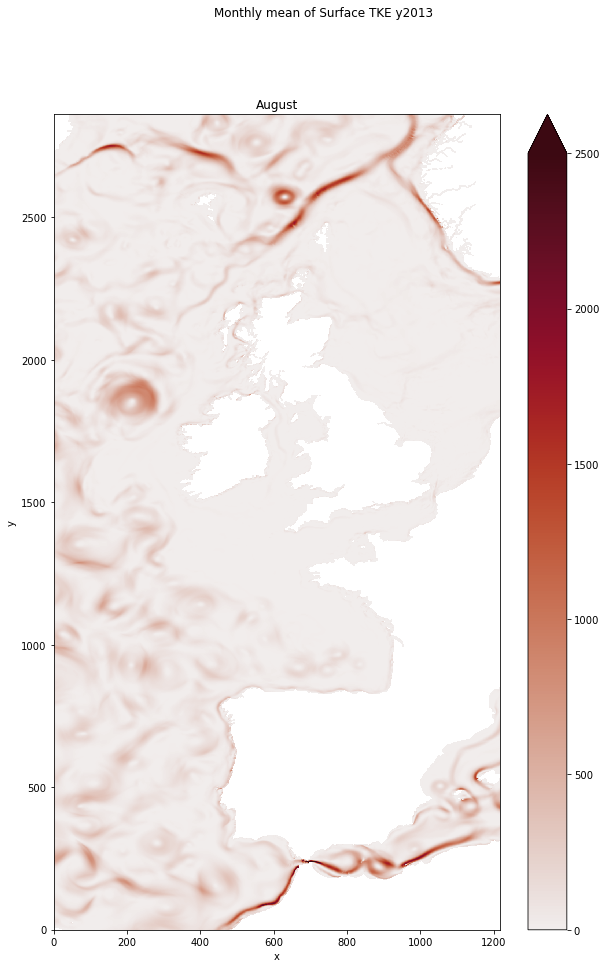

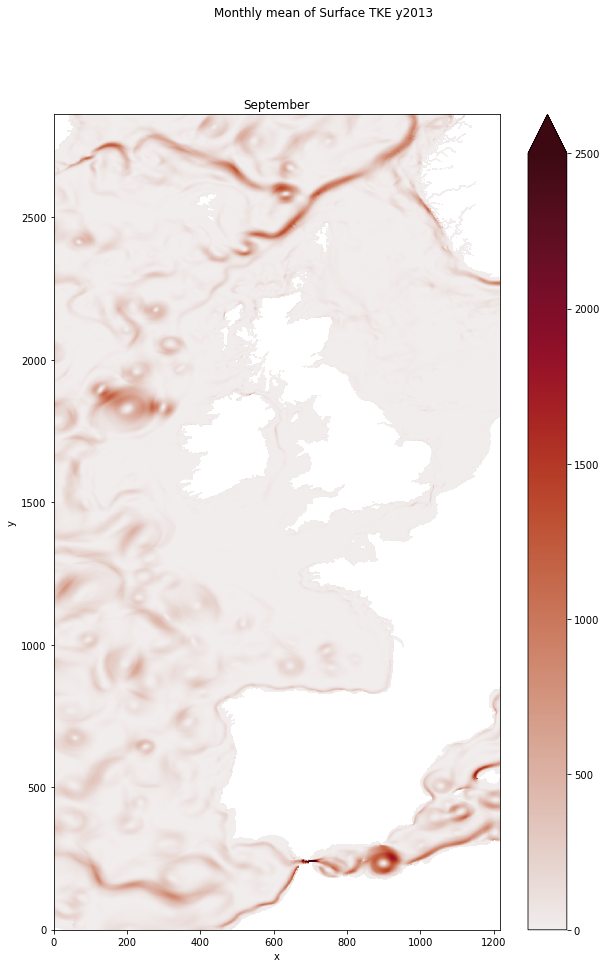

In [12]:
year='2013'
filesU=sorted(glob.glob(datadir+'/*/'+str(config)+'-'+str(case)+'_y????m??d??.'+str(freq)+'_gridU.nc'))
filesV=sorted(glob.glob(datadir+'/*/'+str(config)+'-'+str(case)+'_y????m??d??.'+str(freq)+'_gridV.nc'))
dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':10,'depthu':1})
dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':10,'depthv':1})
u=dsU.sel(time_counter=slice('2013-01-01','2013-09-30')).vozocrtx[:,:,424:3286,3858:5076]
v=dsV.sel(time_counter=slice('2013-01-01','2013-09-30')).vomecrty[:,:,424:3286,3858:5076]
mask=dsmask.tmask[0,:,424:3286,3858:5076]
u2=u*u
v2=v*v
u2mean=u2.mean(dim='time_counter')
v2mean=v2.mean(dim='time_counter')
umonth=u.groupby('time_counter.month').mean('time_counter')
vmonth=v.groupby('time_counter.month').mean('time_counter')
umonth2=umonth*umonth
vmonth2=vmonth*vmonth
tke=compute_TKE(umonth2,vmonth2)
for m in np.arange(1,10):
    if not os.path.exists('Plots/'+config+'/Maps/EU/'+config+'-'+case+'y'+str(year)+'m'+str(m)+'_tke_surf.png'):
        print('Plotting for month '+str(m))
        plot_one_month(10000*tke[m-1,0],mask[0],0,2500,'cmo.amp','Surface TKE y'+year,'tke_surf',m,year)
 

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Plotting for month 1
Plotting for month 2
Plotting for month 3


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Plotting for month 4
Plotting for month 5
Plotting for month 6


RuntimeError: NetCDF: HDF error

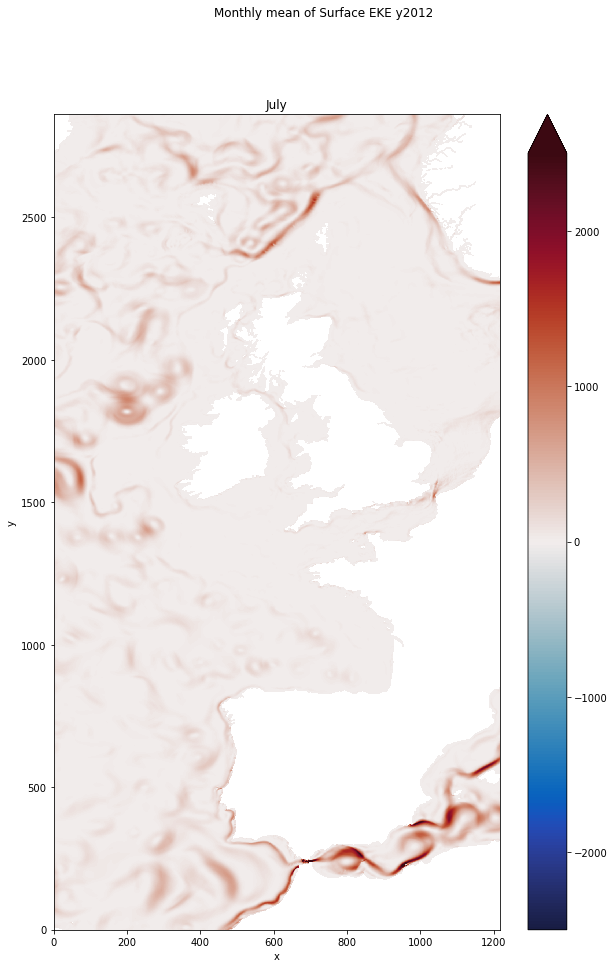

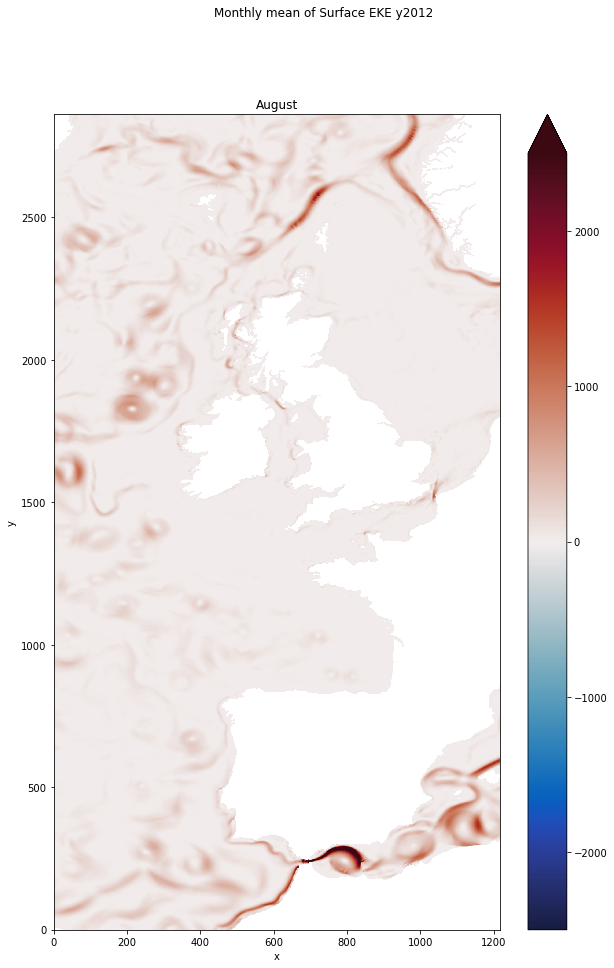

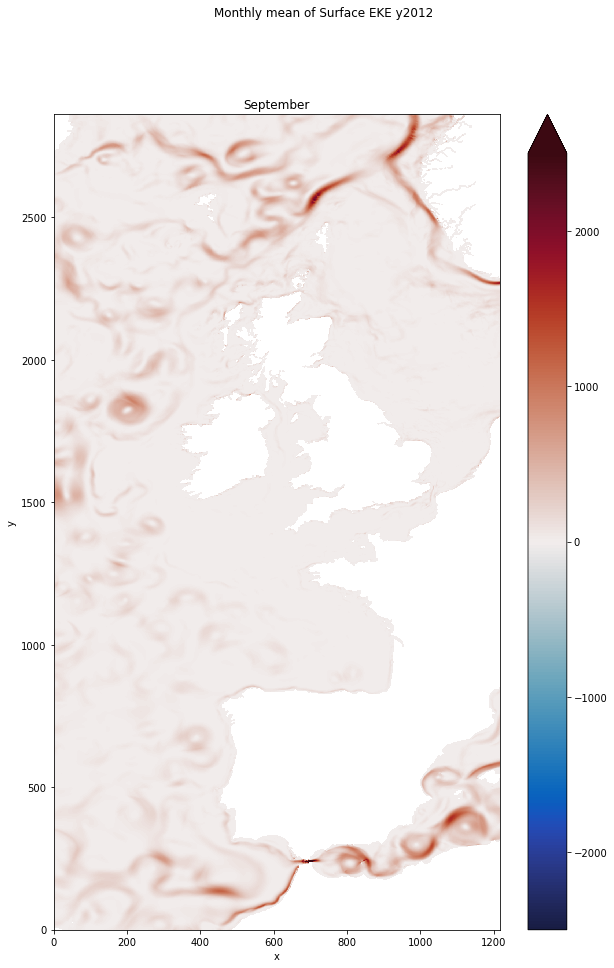

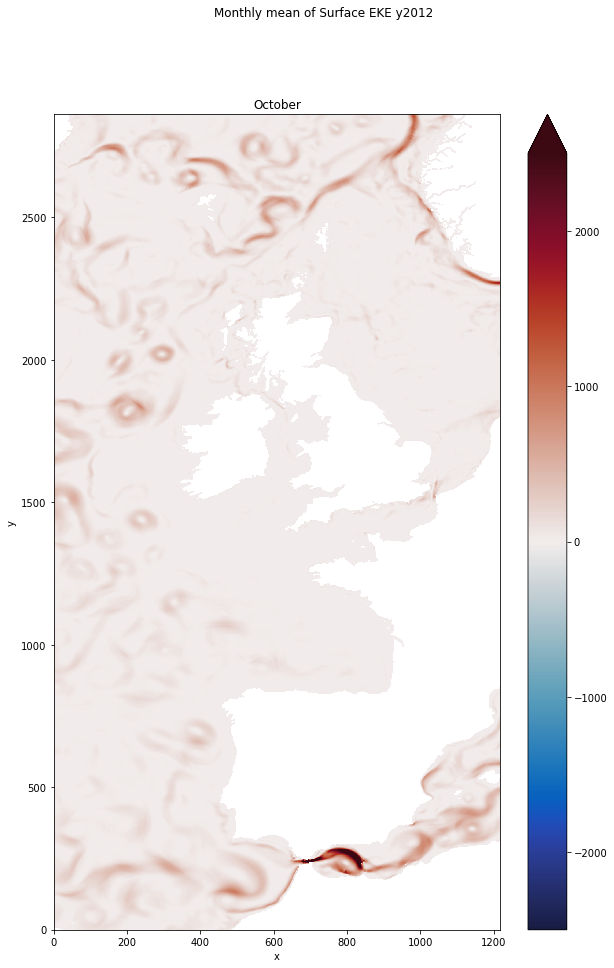

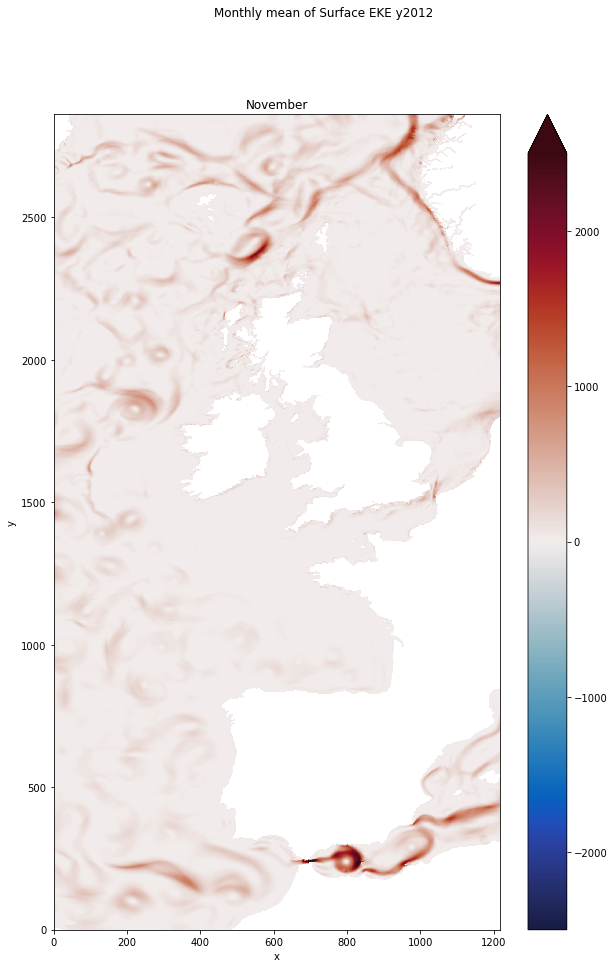

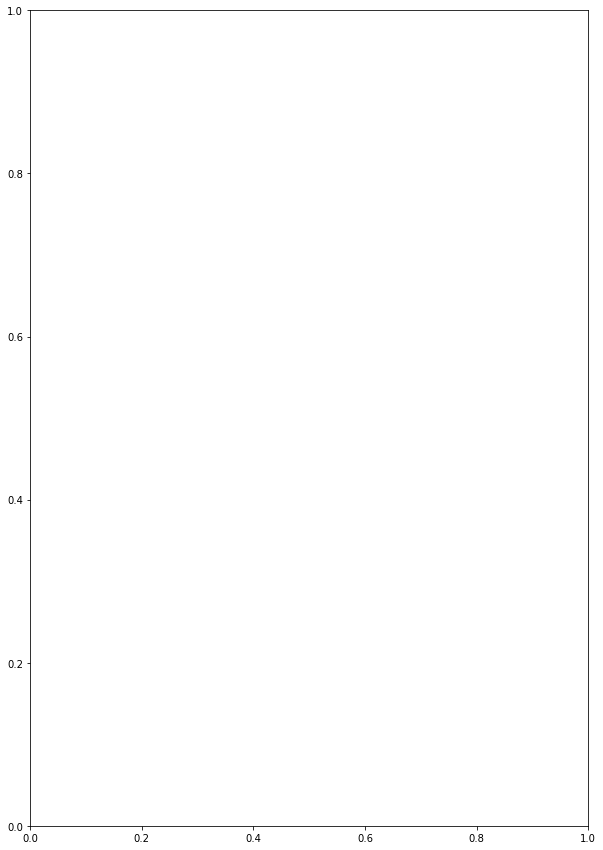

In [14]:
year='2012'
filesU=sorted(glob.glob(datadir+'/*/'+str(config)+'-'+str(case)+'_y????m??d??.'+str(freq)+'_gridU.nc'))
filesV=sorted(glob.glob(datadir+'/*/'+str(config)+'-'+str(case)+'_y????m??d??.'+str(freq)+'_gridV.nc'))
dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':10,'depthu':1})
dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':10,'depthv':1})
u=dsU.sel(time_counter=slice('2012-07-01','2012-12-31')).vozocrtx[:,:,424:3286,3858:5076]
v=dsV.sel(time_counter=slice('2012-07-01','2012-12-31')).vomecrty[:,:,424:3286,3858:5076]
mask=dsmask.tmask[0,:,424:3286,3858:5076]
u2=u*u
v2=v*v
u2mean=u2.mean(dim='time_counter')
v2mean=v2.mean(dim='time_counter')
umonth=u.groupby('time_counter.month').mean('time_counter')
vmonth=v.groupby('time_counter.month').mean('time_counter')
umonth2=umonth*umonth
vmonth2=vmonth*vmonth
tke=compute_TKE(umonth2,vmonth2)
for m in np.arange(1,7):
    month=m+6
    if not os.path.exists('Plots/'+config+'/Maps/EU/'+config+'-'+case+'y'+str(year)+'m'+str(month)+'_tke_surf.png'):
        print('Plotting for month '+str(m))
        plot_one_month(10000*tke[m-1,0],mask[0],-2500,2500,'cmo.balance','Surface EKE y'+year,'tke_surf',month,year)
 